In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
import warnings; warnings.simplefilter('ignore')
import sys
import h5py
import pandas as pd
import seaborn as sns
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_ancillary
import jsm_visualize
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models
import evolve as ev
import galhalo as gh
import profiles as profiles
import config as cfg

In [3]:
plt.style.use('../../SatGen/notebooks/paper1/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches
levelz = [1-0.99, 1-0.95, 1-0.68]

In [4]:
satgen = pd.read_csv("../data/DF_down/summary.csv")
bolshoi = pd.read_csv("../data/sim_data/bolshoi_summary.csv")
sim = pd.read_csv("../data/sim_data/SMDPL_summary.csv")

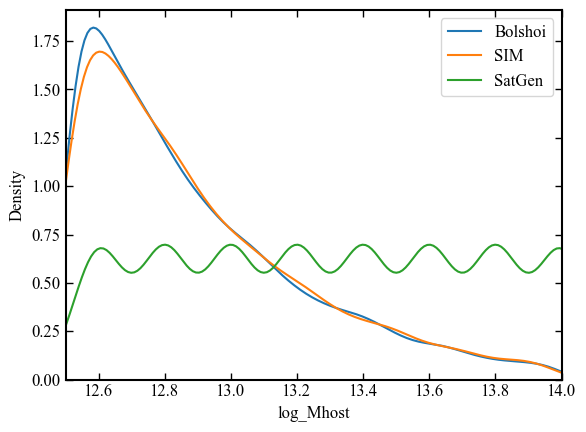

In [5]:
sns.kdeplot(bolshoi["log_Mhost"], label="Bolshoi")
sns.kdeplot(sim["log_Mhost"], label="SIM")
sns.kdeplot(satgen["log_Mhost"], label="SatGen")

plt.xlim(12.5, 14)
plt.legend()

In [6]:
def make_binned_plot(datasets):

    lgM_min = [12.5, 12.7, 12.9, 13.1, 13.3, 13.5, 13.7, 13.9]
    lgM_max = [12.7, 12.9, 13.1, 13.3, 13.5, 13.7, 13.9, 14.1]

    k_tot = len(datasets)
    n_bins = len(lgM_min)

    colorz = ["C0", "C1", "C2"]

    # ---------------------------------------
    # Storage for correlation coefficients
    # ---------------------------------------
    rho_array = np.zeros((k_tot, n_bins))

    fig, axes = plt.subplots(
        k_tot, n_bins,
        figsize=(20, 10),
        sharey=True,
        sharex=True
    )

    # Column titles
    for i in range(n_bins):
        label = rf"$10^{{{lgM_min[i]:.1f}}} < M_{{\rm h}} \leq 10^{{{lgM_max[i]:.1f}}}$"
        axes[0, i].set_title(label)

    # Main plotting loop
    for k, dataset in enumerate(datasets):

        for i in range(n_bins):

            subsample = (
                (dataset["log_Mhost"] > lgM_min[i]) &
                (dataset["log_Mhost"] <= lgM_max[i])
            )

            x = dataset["delta_a50"][subsample]
            y = dataset["delta_Nsub"][subsample]

            N = len(x)

            axes[k, i].scatter(
                x,
                y,
                marker=".",
                s=1,
                alpha=1,
                color=colorz[k]
            )

            axes[k, i].axhline(0, ls="--", color="k")
            axes[k, i].axvline(0, ls="--", color="k")

            qs, rho, p_val = jsm_stats.quadrant_percentages_plot(x, y)

            # ---------------------------------------
            # SAVE rho here
            # ---------------------------------------
            rho_array[k, i] = float(rho)

            axes[k, i].text(0.7, 0.9,  qs[0], fontsize=10, transform=axes[k, i].transAxes)
            axes[k, i].text(0.7, 0.05, qs[1], fontsize=10, transform=axes[k, i].transAxes)
            axes[k, i].text(0.1, 0.05, qs[2], fontsize=10, transform=axes[k, i].transAxes)
            axes[k, i].text(0.1, 0.9,  qs[3], fontsize=10, transform=axes[k, i].transAxes)

            rho_label = "$\\rho_S$=" + rho + f"\nN={N}"

            axes[k, i].text(
                0.65, 0.15,
                rho_label,
                fontsize=11,
                color="red" if p_val < 0.05 else "grey",
                transform=axes[k, i].transAxes,
                bbox=dict(boxstyle="round", facecolor="white")
            )

        axes[k, 0].set_ylabel(r"$\Delta \, \log N_{\rm sub}$")

    for i in range(n_bins):
        axes[-1, i].set_xlabel(r"$\Delta \, \log \, a_{1/2}$")

    plt.tight_layout()
    plt.savefig("../figures/fid.pdf")

    # ---------------------------------------
    # RETURN correlation coefficients
    # ---------------------------------------
    return rho_array

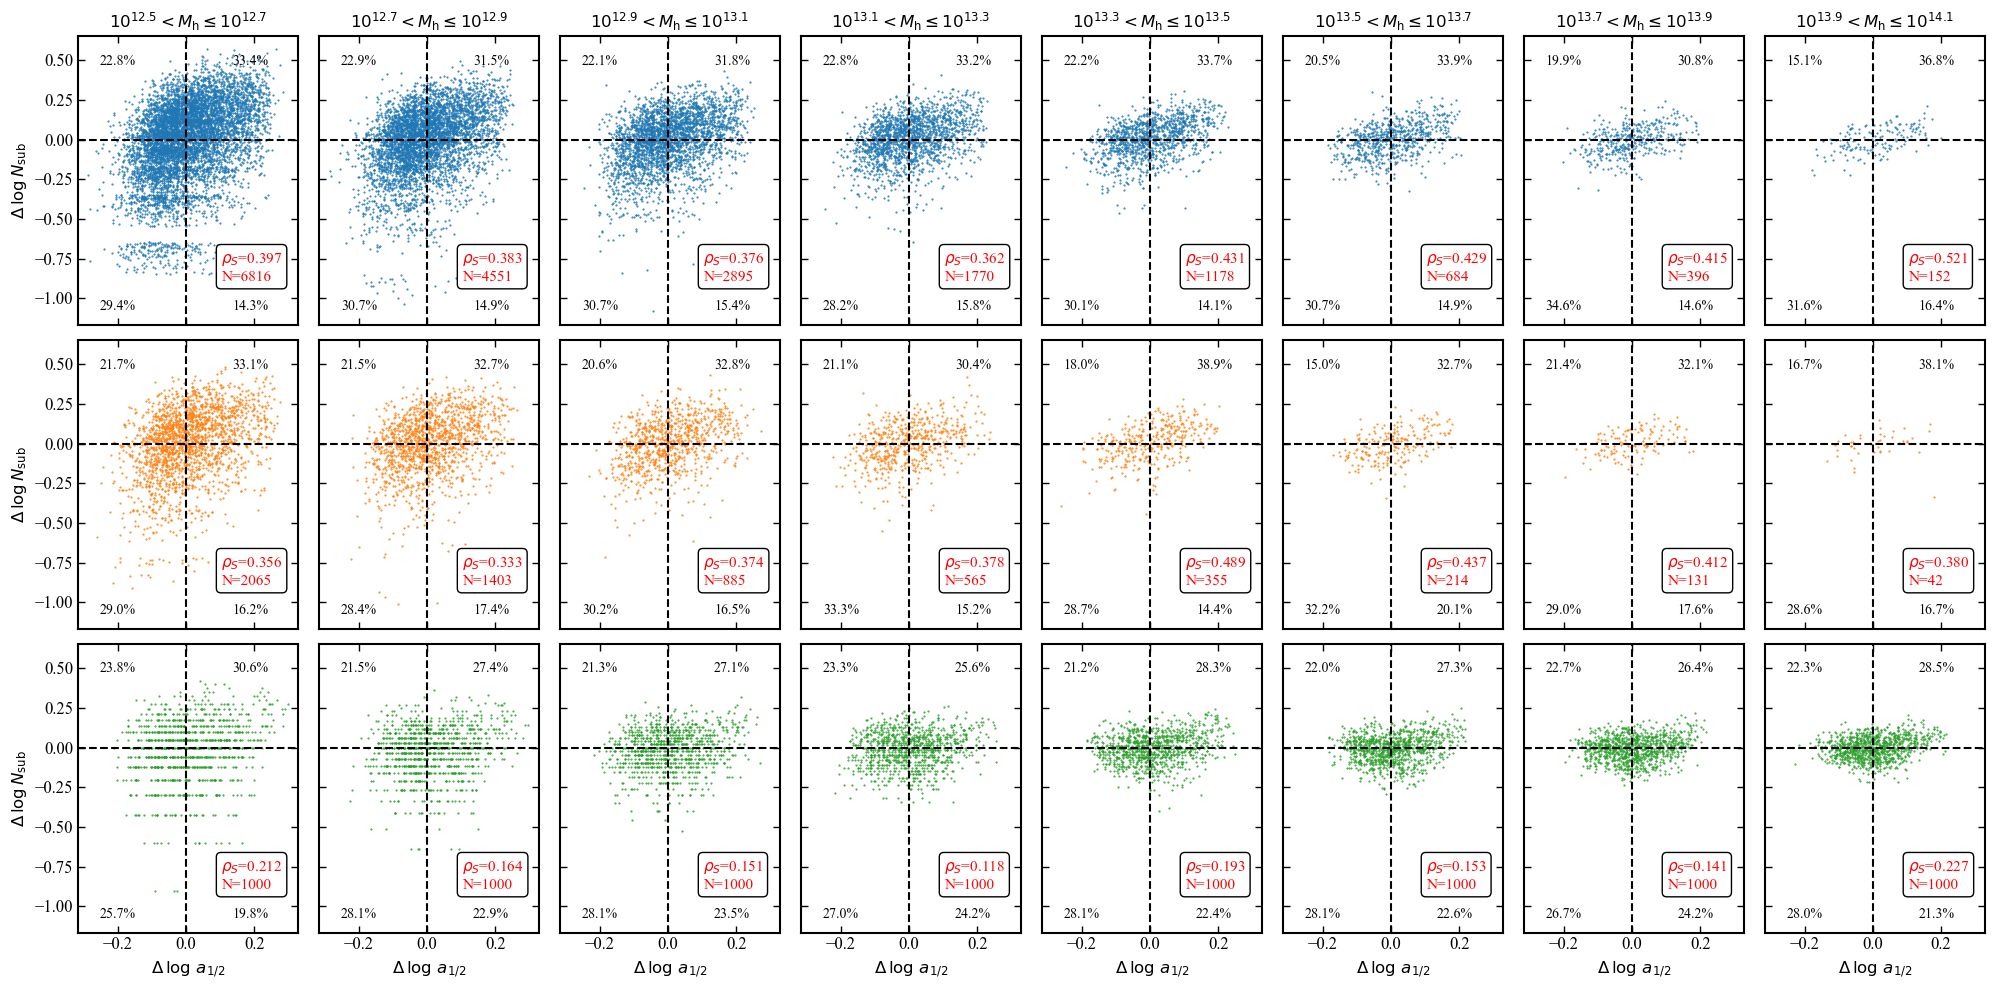

In [7]:
rhos = make_binned_plot([bolshoi, sim, satgen])

In [8]:
rhos[2]

array([0.212, 0.164, 0.151, 0.118, 0.193, 0.153, 0.141, 0.227])